In [1]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    activations_pretrained.clear()
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    # print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model(arch='resnet56',data='cifar10'):
    import os
    import sys
    path = False
    sys.path.append("/ssd5/Roy/pytorch_resnet_cifar10-master")
    if data == 'cifar10':
        import resnet_cifar10
        if arch == 'resnet56':
            model = resnet_cifar10.__dict__[arch]()
            path=os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
        elif arch == 'resnet110':
            model = resnet_cifar10.__dict__[arch]()
            path=os.path.join('/ssd5/Roy/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    elif data == 'cifar100':
        import resnet_cifar100
        if arch == 'resnet56':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
        elif arch == 'resnet110':
            model = resnet_cifar100.__dict__[arch]()
            path = "/ssd5/Roy/pytorch_resnet_cifar10-master/save_resnet110_cifar100/best_model.th"
    elif data == 'imagenet':
        if arch == 'resnet50':
            from torchvision.models import resnet50, ResNet50_Weights
            model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        elif arch == 'resnet101':
            from torchvision.models import resnet101, ResNet101_Weights
            model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(
            f"Invalid dataset '{data}'. Supported options are: 'cifar10', 'cifar100', 'imagenet'."
        )

    if path:
        checkpoint = torch.load(path)
        state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

        new_state_dict = {}
        for key, value in state_dict.items():
            new_key = key.replace("module.", "")  # 移除 module.
            new_state_dict[new_key] = value

        model.load_state_dict(new_state_dict)

    return model

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]


def StatTest(test, arch, data):

    # 獲取預訓練權重的激活
    pretrained_model = load_pretrained_model(arch=arch,data=data)
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

    rows = []
    n = len(activations_pretrained_copy)
    for i in range(1, n):
        # Pretrained 模型
        act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
        act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

        act_before_pre = remove_outliers(act_before_pre)
        act_after_pre = remove_outliers(act_after_pre)

        if test == 'MW':
            # Mannwhitneyu
            u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')
        elif test == 'KS':
            # KS
            u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
        sig_pre = "*" if p_val_pre < 0.05 else ""
        mean_pre = np.mean(act_after_pre)
        std_pre = np.std(act_after_pre)

        # 使用 pretrained 模型當前 block 的輸出形狀作為參考
        output_shape = activations_pretrained_copy[i].shape
        
        rows.append([i, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

    # 建立 DataFrame
    columns = ['block_index', 
            'output shape', 
            'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val']
    df_stats = pd.DataFrame(rows, columns=columns)
    return df_stats


In [2]:
test = 'KS'
arch = 'resnet56'
data = 'cifar100'

import time  # 加在最上面
start_time = time.time()  # 開始時間

device = torch.device("cpu")
activations_pretrained = []
hooks_pretrained = []
df_stats = StatTest(test=test, arch=arch, data=data)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))

Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Total elapsed time: 11.62 seconds


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,p_val
1,"torch.Size([1, 16, 32, 32])",0.544750,0.536887,*,0.000000
2,"torch.Size([1, 16, 32, 32])",0.612025,0.562521,*,0.000000
3,"torch.Size([1, 16, 32, 32])",0.680346,0.608325,*,0.000000
4,"torch.Size([1, 16, 32, 32])",0.759019,0.657490,*,0.000000
5,"torch.Size([1, 16, 32, 32])",0.838130,0.710476,*,0.000000
6,"torch.Size([1, 16, 32, 32])",0.908939,0.726774,*,0.000000
7,"torch.Size([1, 16, 32, 32])",0.959728,0.757536,*,0.000000
8,"torch.Size([1, 16, 32, 32])",1.003278,0.708594,*,0.000000
9,"torch.Size([1, 32, 16, 16])",0.368790,0.399850,*,0.000000
10,"torch.Size([1, 32, 16, 16])",0.433444,0.422180,*,0.000000


In [3]:
num_runs = 5
summary_rows = []
start_time = time.time()

for run_idx in range(1, num_runs+1):
    device = torch.device("cpu")
    activations_pretrained = []
    hooks_pretrained = []
    df_stats = StatTest(test=test, arch=arch, data=data)

    redundant_blocks = df_stats[df_stats['p_val'] > 0.05]['block_index'].tolist()
    redundant_blocks_str = ','.join(map(str, redundant_blocks))
    num_redundant = len(redundant_blocks)
    summary_rows.append([run_idx, redundant_blocks_str, num_redundant])

    summary_df = pd.DataFrame(
        summary_rows,
        columns=['run_index', 'redundant_blocks', 'num_redundant_blocks']
    )
    
print("\nSummary across 5 runs:")
elapsed_time = time.time() - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(summary_df.style.hide(axis="index"))

Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Summary across 5 runs:

Total elapsed time: 57.11 seconds


run_index,redundant_blocks,num_redundant_blocks
1,"15,20,21,22",4
2,"15,20,21",3
3,"20,21,22",3
4,"20,21,22",3
5,"20,21,22",3


# N次裡面挑出現k次的(演算法)，這件事情做100次(驗證)

In [4]:
from collections import Counter
import pandas as pd
import time

num_outer_runs = 100  # 外層重複幾次
num_inner_runs = 5    # 每次投票裡面做幾次
at_least_show = 3     # 至少出現幾次就算

summary_rows = []
start_time = time.time()

for outer_idx in range(1, num_outer_runs + 1):
    all_blocks_this_outer = []

    for inner_idx in range(num_inner_runs):
        df_stats = StatTest(test=test, arch=arch, data=data)
        redundant_blocks = df_stats[df_stats['p_val'] > 0.05]['block_index'].tolist()
        all_blocks_this_outer.extend(redundant_blocks)

    # 統計 5 次裡面每個 block 出現次數
    counts = Counter(all_blocks_this_outer)

    # 投票條件：至少出現 3 次
    voted_blocks = sorted([block for block, count in counts.items() if count >= at_least_show])

    voted_blocks_str = ','.join(map(str, voted_blocks))
    num_voted = len(voted_blocks)

    summary_rows.append([outer_idx, voted_blocks_str, num_voted])

    print(f"Outer Run {outer_idx}: Voted redundant blocks -> {voted_blocks_str}")

# --- 匯總 ---
summary_df = pd.DataFrame(
    summary_rows,
    columns=['run_index', 'voted_redundant_blocks', 'num_voted_blocks']
)

elapsed_time = time.time() - start_time
print(f"\nTotal elapsed time for {num_outer_runs} outer runs: {elapsed_time:.2f} seconds")

# 顯示或儲存
print("\nSummary of voted blocks across all runs:")
# print(summary_df.head())

# 組檔名字串
filename = f"summary_{data}_{arch}_{test}_{num_inner_runs}runs_atleast{at_least_show}.csv"

# 儲存
summary_df.to_csv(filename, index=False)

print(f"Saved summary to: {filename}")

# --- 檢查是否完全一致 ---
unique_sets = summary_df['voted_redundant_blocks'].nunique()
if unique_sets == 1:
    print("\n🎉 All runs produced the same voted redundant block set! Very stable!")
else:
    print(f"\n⚠️ Found {unique_sets} different voted block sets across {num_outer_runs} runs.")

summary_df


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 1: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 2: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 3: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 4: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 5: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 6: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 7: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 8: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 9: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 10: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 11: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 12: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 13: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 14: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 15: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 16: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 17: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 18: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 19: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 20: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 21: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 22: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 23: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 24: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 25: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 26: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 27: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 28: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 29: Voted redundant blocks -> 13,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 30: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 31: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 32: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 33: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 34: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 35: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 36: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 37: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 38: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 39: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 40: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 41: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 42: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 43: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 44: Voted redundant blocks -> 20,21


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 45: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 46: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 47: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 48: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 49: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 50: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 51: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 52: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 53: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 54: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 55: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 56: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 57: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 58: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 59: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 60: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 61: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 62: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 63: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 64: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 65: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 66: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 67: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 68: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 69: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 70: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 71: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 72: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 73: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 74: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 75: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 76: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 77: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 78: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 79: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 80: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 81: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 82: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 83: Voted redundant blocks -> 13,15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 84: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 85: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 86: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 87: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 88: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 89: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 90: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 91: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 92: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 93: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 94: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 95: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 96: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 97: Voted redundant blocks -> 15,20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 98: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 99: Voted redundant blocks -> 20,21,22


Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/hsujenlung/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Outer Run 100: Voted redundant blocks -> 20,21,22

Total elapsed time for 100 outer runs: 7605.05 seconds

Summary of voted blocks across all runs:
Saved summary to: summary_cifar100_resnet56_KS_5runs_atleast3.csv

⚠️ Found 5 different voted block sets across 100 runs.


,run_index,voted_redundant_blocks,num_voted_blocks
0,1,"20,21,22",3
1,2,"20,21,22",3
2,3,"20,21,22",3
3,4,"20,21,22",3
4,5,"20,21,22",3
...,...,...,...
95,96,"20,21,22",3
96,97,"15,20,21,22",4
97,98,"20,21,22",3
98,99,"20,21,22",3


In [5]:
from collections import Counter

# 攤平成一個大串列
all_blocks = []
for row in summary_df['voted_redundant_blocks']:
    blocks = row.split(',')
    all_blocks.extend(blocks)

counts = Counter(all_blocks)
print("\nBlock 出現次數統計：")
for block, count in counts.most_common():
    print(f"Block {block}: {count} times, {count/100:.1%}")



Block 出現次數統計：
Block 20: 100 times, 100.0%
Block 21: 100 times, 100.0%
Block 22: 99 times, 99.0%
Block 15: 23 times, 23.0%
Block 13: 2 times, 2.0%


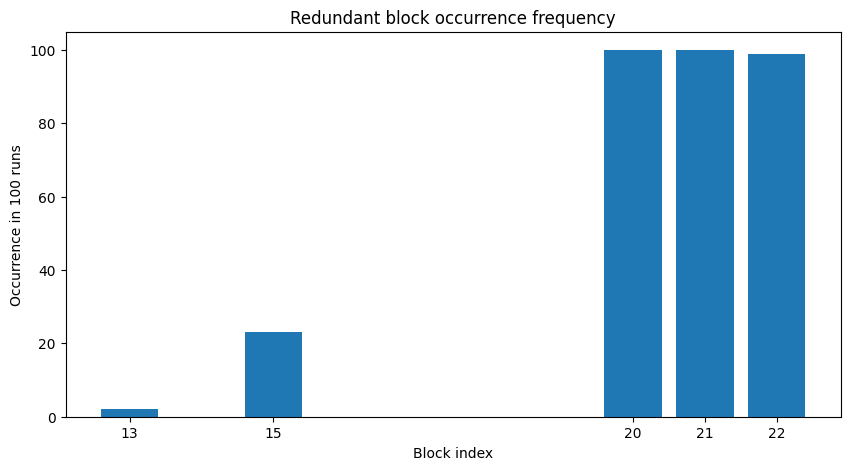

In [6]:
import matplotlib.pyplot as plt

blocks = list(map(int, counts.keys()))
freqs = list(counts.values())

plt.figure(figsize=(10, 5))
plt.bar(blocks, freqs)
plt.xlabel("Block index")
plt.ylabel("Occurrence in 100 runs")
plt.title("Redundant block occurrence frequency")
plt.xticks(blocks)
plt.show()
